# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [3]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [4]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [5]:
#Computing ECDF (Empirical cumulative distribution function)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

#### Is the distribution of body temperatures normal?  
#### Graphical Method

Plotting the histogram and Cumulative Distribution Function (CDF) of the experimental data together with a theoretical generated normal distribution with the mean and STD of the experimental data, it is possible to determine visually if the experimental data actually follows a normal distribution.

According to the graph below,  the experimental body temperature follows a normal distribution

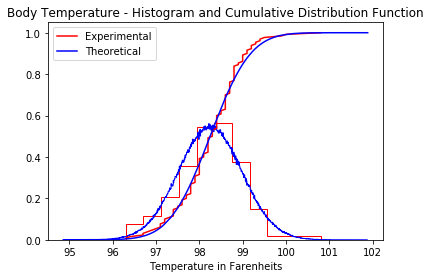

In [6]:
#Calculate Empirical cumulative distribution of Experimental data
x, y= ecdf(df['temperature'])
#Calculate Number of Bins for histogram
bins1=round(len(df['temperature'])**(1/2))

#Plot histogram and ECDF of experimental data
_=plt.hist(df['temperature'], density=True, bins=bins1, histtype='step', color='red')
_=plt.plot(x, y, color='red')

#Generate theoretical normal distribution with mean and STD of experimental data
mu=df['temperature'].mean()
sigma=df['temperature'].std()
the_normal=np.random.normal(loc=mu, scale=sigma, size=1000000)
#Calculate Empirical cumulative distribution of theoretical data
x_theo, y_theo= ecdf(the_normal)
#Calculate Number of Bins for histogram
bins2=round(len(the_normal)**(1/2))


#Plot histogram and ECDF of theoretical data
_=plt.hist(the_normal, density=True, bins=bins2, histtype='step', color='blue')
_=plt.plot(x_theo, y_theo, color='blue')

#Plot settings
_=plt.xlabel('Temperature in Farenheits')
_=plt.title('Body Temperature - Histogram and Cumulative Distribution Function')
_=plt.legend(('Experimental', 'Theoretical'))
plt.show()

#### Is the sample size large? 

The sample size is big considered big enough if the following conditions are met:

1. n*phat>=10 required to assume enough counts of success 
2. n*(1-phat)>=10 required to assume enough counts of failures

n: Sample size
phat:sample proportion


In our sample of body temperature of 130 samples, phat(t=98.6) is aproximatly 0.6 according to the above histogram.
Thus:
130*0.6=78 --> n*phat>=10
130*0.4= 52 --> n*(1-phat)>=10

The conditions 1 and 2 are met, therefore it is considered that the sample size is large enough.


#### Are the observations independent?

n<=10% population is required to assume independent observations when there is not replacement

In the case of body temperature data under study, the observations are considered independent because the population size is around 170millions of people in the world and the sample size is 130 people which is less than 10% of the population

###  Is the true population mean really 98.6 degrees F?

#### Bootstrap hypothesis test

In order to test that the real population mean is 98.6 by using Boostrap hypothesis test:

1.- Null hypotesis: population mean = 98.6 

2.- Test statistics for this case is the mean

3.- Generate many sets of simulated data assuming the null hypotesis is true
    - Translate the sample data to have the population mean
    - Generate boostrap replicates of the translated data and compute the test statistic for each data set

4.- Calculate p-value which is the fraction of the simulated data sets for which the test statistics is at least as extreme as for the real data (observed data)

It was obtained that the probability of obtaining a sample mean of 98.6 in case the null hypothesis is true is almost zero. It means the NULL hypothesis is not true


**It is very unlikely that expected value of the body temperature is 98.6**

In [7]:
#Generate one boostrap
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

#generate meany boostrap replicates	
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

test statistic observed =  98.24923076923078
SEM  of real data =  0.06405661469519336
standard deviation of bootstrap replicates =  0.06469918233645558
p (test_statistic<= test_statistic_observed) =  0.0


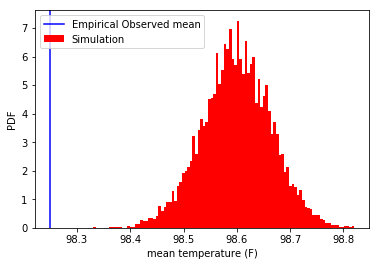

In [21]:
#Observed data
data=df['temperature'].copy()
test_statistic_observed=data.mean()
print('test statistic observed = ',test_statistic_observed)

#Translate data 
translated_data=data-data.mean()+98.6

# Take 10,000 bootstrap replicates of the mean: bs_replicates
size=10000
bs_replicates = draw_bs_reps(translated_data, np.mean, size=size)
bins=round(size**(1/2))

# Compute and print SEM (standard error of the mean)
sem = np.std(data) / np.sqrt(len(data))
print('SEM  of real data = ', sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('standard deviation of bootstrap replicates = ',bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=bins, density=True, color='red')
_ = plt.axvline(x=test_statistic_observed, color='blue')
_ = plt.xlabel('mean temperature (F)')
_ = plt.ylabel('PDF')
_ = plt.legend(('Empirical Observed mean', 'Simulation'), loc='upper left')


# Compute fraction of replicates which t-statistic is at least as extreme 
#as for the real data: p
p = np.sum(bs_replicates <= test_statistic_observed) / size


# Print the p-value
print('p (test_statistic<= test_statistic_observed) = ', p)

# Show the plot
plt.show()


#### Frequentist statistical testing

*It will be used t statistics instead Z statistics because the population mean is unknown*

Check of conditions for t interval:

1.- Random sampling

2.- Central theorema limit indicates that the distribution of the sample mean would be normal regardless of the distribution of the data if the sample mean size is at least 30

3.- sample size n<=10%population 

All the above conditions are met. Thus we can use t-statistics.



In [9]:
# Student t-distribution Percent Point Function
from scipy.stats import t

#Observed data
#data=df['temperature'].copy()
n=len(data)
Xmean=data.mean()
S=np.std(data)
confidence_level=0.99
dfreedom=n-1 #degree of freedom

#--------------------------

t_critical=t.ppf((1-confidence_level)/2, dfreedom)
print('t_critical', t_critical)
# Compute and print SEM (standard error of the mean)
sem = np.std(data) / np.sqrt(len(data))

value_1=Xmean+t_critical*sem
value_2=Xmean-t_critical*sem

print(confidence_level*100, '% confidence interval: ',value_1, value_2 )

t_critical -2.614478679699783
99.0 % confidence interval:  98.08175611581645 98.41670542264511


*the frequency statistic testing also indicate that 98.6 is out of the 99% confience interval*


 #### what temperature should we consider someone's temperature to be "abnormal"?
 
 The abnormal temperature should be those that are out of the 99% confidence interval calculated with the t_critical. Nevertheless, it will be simulated with boostraps below for verification purposes.
 
 Abnormal temperatures: 98.08>body temperatures >98.42

test statistic observed =  98.24923076923078
SEM  of real data =  0.06405661469519336
standard deviation of bootstrap replicates =  0.06389467757093308
confidence interval of bootstrap replicates =  [98.08769231 98.41462308]


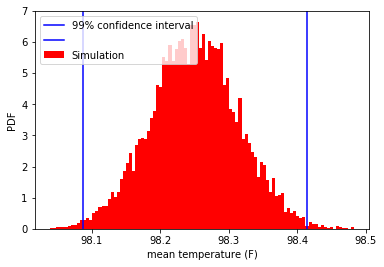

In [20]:
#Observed data
test_statistic_observed=data.mean()
print('test statistic observed = ',test_statistic_observed)


# Take 10,000 bootstrap replicates of the mean: bs_replicates
size=10000
bs_replicates = draw_bs_reps(data, np.mean, size=size)
bins=round(size**(1/2))

# Compute and print SEM (standard error of the mean)
sem = np.std(data) / np.sqrt(len(data))
print('SEM  of real data = ', sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('standard deviation of bootstrap replicates = ',bs_std)

#confidence intervalo of 99%
percentiles=np.percentile(bs_replicates,[0.5,99.5])
print('confidence interval of bootstrap replicates = ',percentiles)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=bins, density=True, color='red')
_ = plt.axvline(x=percentiles[0], color='blue')
_ = plt.axvline(x=percentiles[1], color='blue')
_ = plt.xlabel('mean temperature (F)')
_ = plt.ylabel('PDF')
_ = plt.legend(('99% confidence interval','' ,'Simulation'), loc='upper left')



# Show the plot
plt.show()


#### Is there a significant difference between males and females in normal temperature?

1.- Null hypotesis: there is not a significant difference

2.- Test statistics for this case is the empirical mean difference between male and female body temperatures

3.- Generate many sets of simulated data assuming the null hypotesis is true
    - Generate boostrap replicates by permutations of  the two data sets (Female and Male)
    - Compute the test statistic for each data set

4.- Calculate p-value which is the fraction of the simulated data sets for which the test statistics is at least as extreme as for the real data (observed data)

We got a p-value of 0.0117, which suggests that there is not a statistically significant difference.



In [11]:
#Generating a permutable sample

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [12]:
#Generating permutation replicates

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

In [13]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = data_1.mean()-data_2.mean()

    return diff

In [14]:
data_F=df[df['gender']=='F']['temperature']
data_M=df[df['gender']=='M']['temperature']

p-value = 0.0128


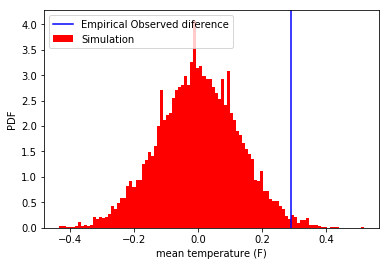

In [15]:
# Compute difference of mean female and male body temperatures from experiment: empirical_diff_means
test_statistic_observed = diff_of_means(data_F, data_M)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(data_F, data_M,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= test_statistic_observed) / len(perm_replicates)

# Make a histogram of the results
_ = plt.hist(perm_replicates, bins=bins, density=True, color='red')
_ = plt.axvline(x=test_statistic_observed, color='blue')
_ = plt.xlabel('mean temperature (F)')
_ = plt.ylabel('PDF')
_ = plt.legend(('Empirical Observed diference', 'Simulation'), loc='upper left')


# Print the result
print('p-value =', p)

We got a p-value of 0.0117, which suggests that there is not a statistically significant difference between female and male body temperatures

#### Conclusions:
    

There is significant statistical evidence that the mean normal body temperature today differs from the mean normal body temperature of 98.6$^{\circ}$F conceptualized more than 120 years ago by Carl Wunderlich.
According to the data the normal mean body temperature has a 99% confidence interval of [98.08, 98.41]$^ {\circ}$F  beeing 98.6$^ {\circ}$F out of the confidence interval. 
Also, there is not statistical significant difference between female and male body temperatures.

Further abalysis shall be done to study how the mean normal body temperature has changed over the last 120 years



__________________________________________________________________________
<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****